## Prétraitement des données :

## 1.IMPORTATION 

In [1]:
# Librairies de calcul:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

# Libairies de representation graphique:
import matplotlib.pyplot as plt
import seaborn as sns

# Importe de LinearRegression() 
# Avec Sklearn
from sklearn.linear_model import LinearRegression

# Pour la regression logistique:
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score

# Pour le K-mean:
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Avec StatModel
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white , normal_ad

from sklearn import datasets


### Import des donnees d'entrainement

In [4]:
## Import des donnees d'entrainement:
data = pd.read_csv('billets.csv',sep = ';')                  
#données d'entrainement
billets=data.copy()
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [5]:
# Importer le dataset de test
Billets_test_df = pd.read_csv("billets_production.csv")                 
# données de Testing     
Billets_test_df.info()                                                        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 412.0+ bytes


## 2. Vérification

DEFFINITION DES VARIABLES

Dimensions géométriques
Nous disposons actuellement de six informations géométriques sur un billet :

length : la longueur du billet (en mm) ;
height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;
height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
diagonal : la diagonale du billet (en mm).

In [6]:
# donnees d'entrainement:
data.shape

(1500, 7)

In [7]:
# Resume des donnees brutes:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

Nous avons bien six dimensions en plus de la colonne permettant de distinguer les vrais des faux billets qui ne sera pas présente dans nos données réelles. Les types des données sont ceux attendus. Il manque des données seulement pour margin_low, il s'agit de la marge entre le bord inferieur du billet et l'image de celui-ci (en mm).

In [8]:
# Connaître le nombre d'échantillons nuls d'une colonne particulière.
data[data['margin_low'].isna()].shape

(37, 7)

In [9]:
# Vérification du nombre de faux billets
print("nombre de vrai billets :",data.loc[data["is_genuine"]==True]["is_genuine"].count())
print("nombre de faux billets :",data.loc[data["is_genuine"]==False]["is_genuine"].count())

nombre de vrai billets : 1000
nombre de faux billets : 500


## 1. EXPLORATION DESCRIPTIVES DES VARIABLES

In [10]:
# vérifier les valeurs que prend la colonne is_genuine
data['is_genuine'].unique()

array([ True, False])

In [11]:
# valeur en double
data.duplicated().sum()

0

In [12]:
# Identification des lignes ayant des donnees manquantes:
data.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il y a 37 données manquantes sur margin_low, nous allons donc devoir faire une régression linéaire pour les combler et ne pas perdre d'informations.

LES MOYENNES 

In [13]:
# afficher les moyennes de variables
data.mean()

is_genuine        0.666667
diagonal        171.958440
height_left     104.029533
height_right    103.920307
margin_low        4.485967
margin_up         3.151473
length          112.678500
dtype: float64

In [14]:
# rendre binaire is_genuine
billets['is_genuine'].replace([False,True], [0,1], inplace=True)
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

Text(0.5, 1.0, 'Taux des vrais et faux billets')

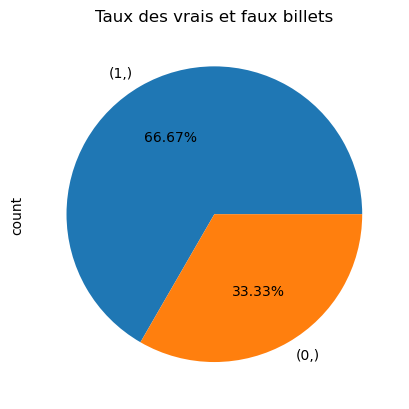

In [15]:
# afficher les taux de faux billets et des vrais billets
billets[['is_genuine']].value_counts().plot.pie(autopct = lambda x: str(round(x, 2)) + '%')
plt.title('Taux des vrais et faux billets')

## 2-EXPLORATION DE LA DISTRIBUTIONS DES VARIABLES ET LES VALEURS ABERRANTES¶

Visualisation des données

La normalité est une condition indispensable à vérifier pour la réalisation des tests paramétriques en statistiques.
Deux méthodes sont à retenir :

La méthode graphique : examen visuel de la représentation graphique (ici un pairplot et une boîte à moustache). 

C:\Users\chthioub\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


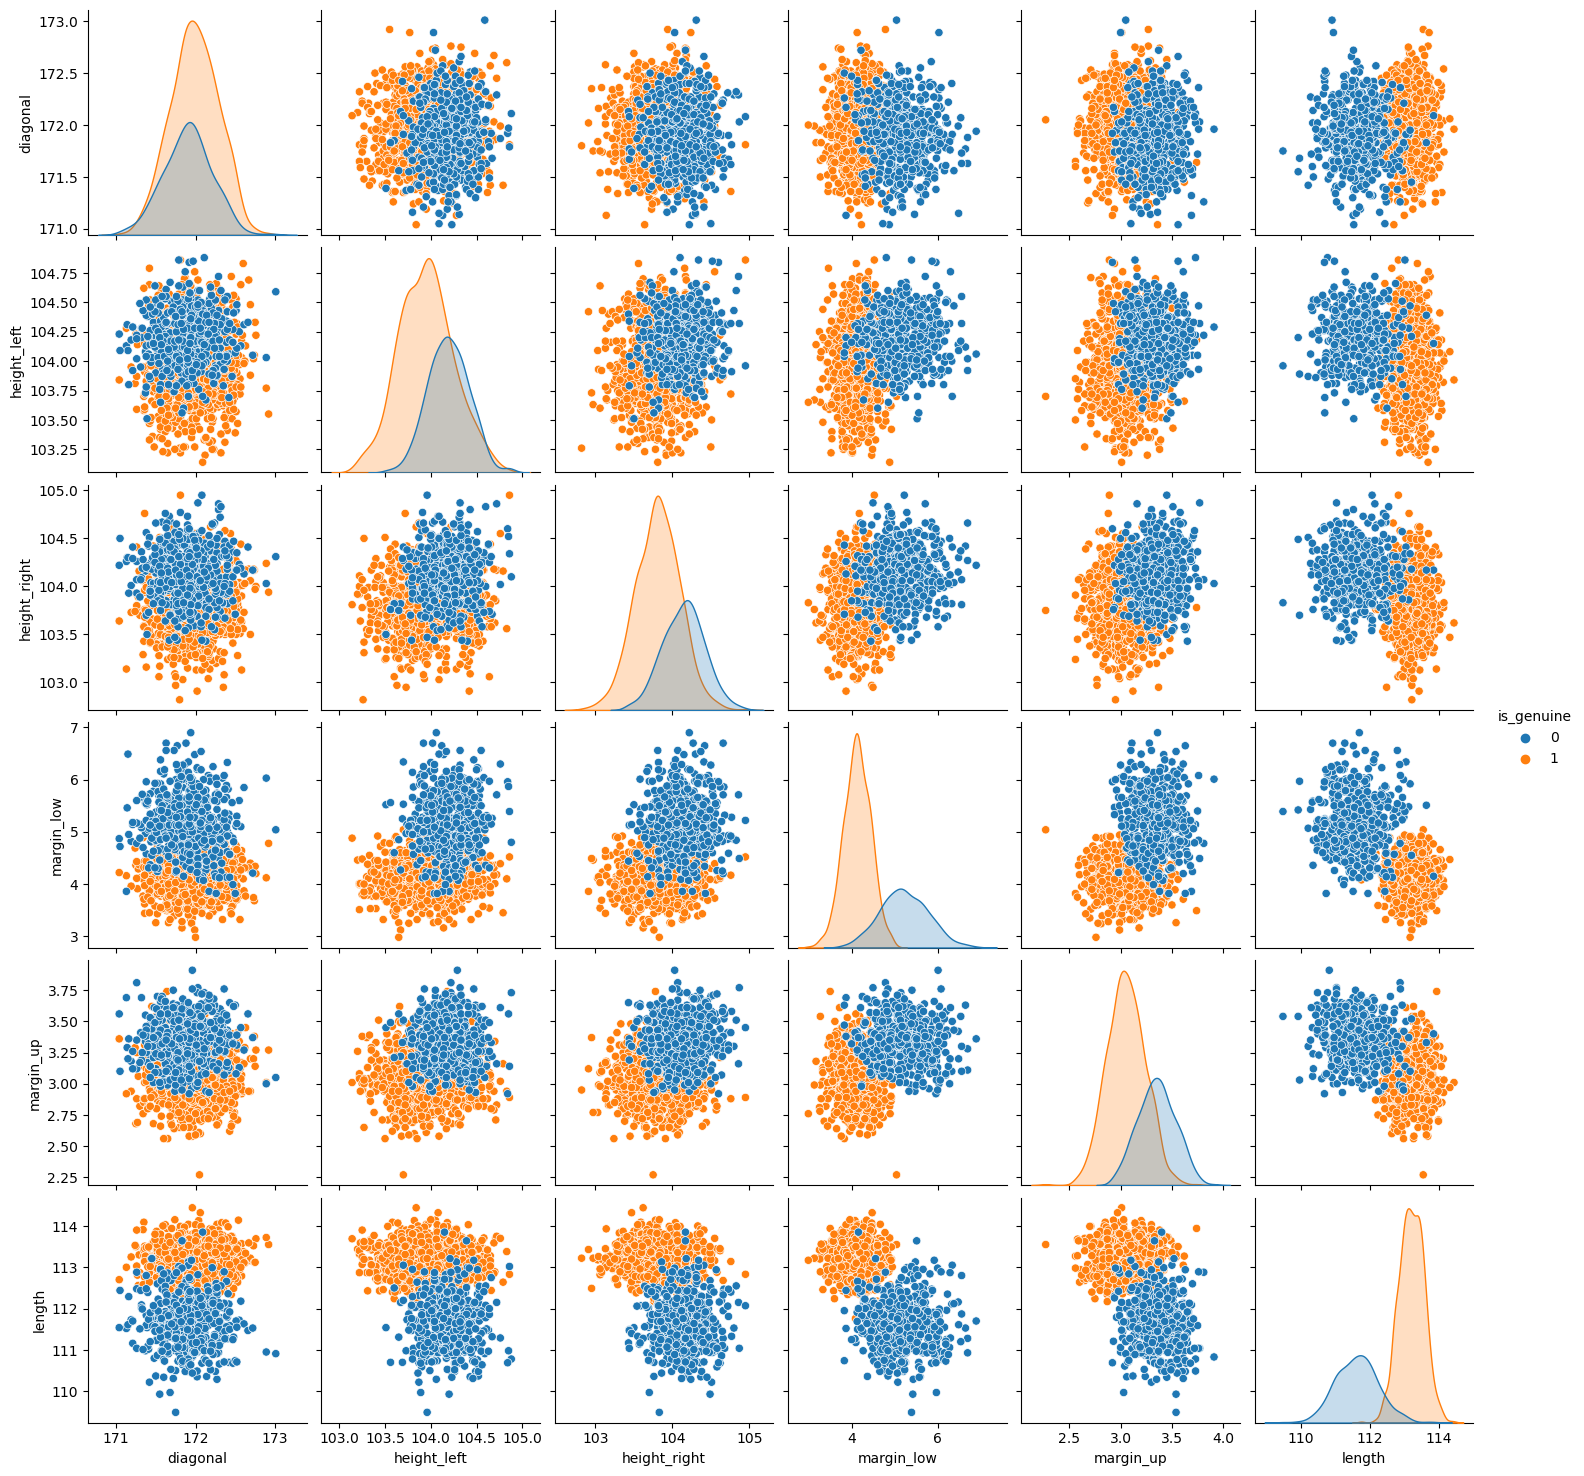

In [16]:
sns.pairplot(billets, hue="is_genuine")

<Axes: ylabel='length'>

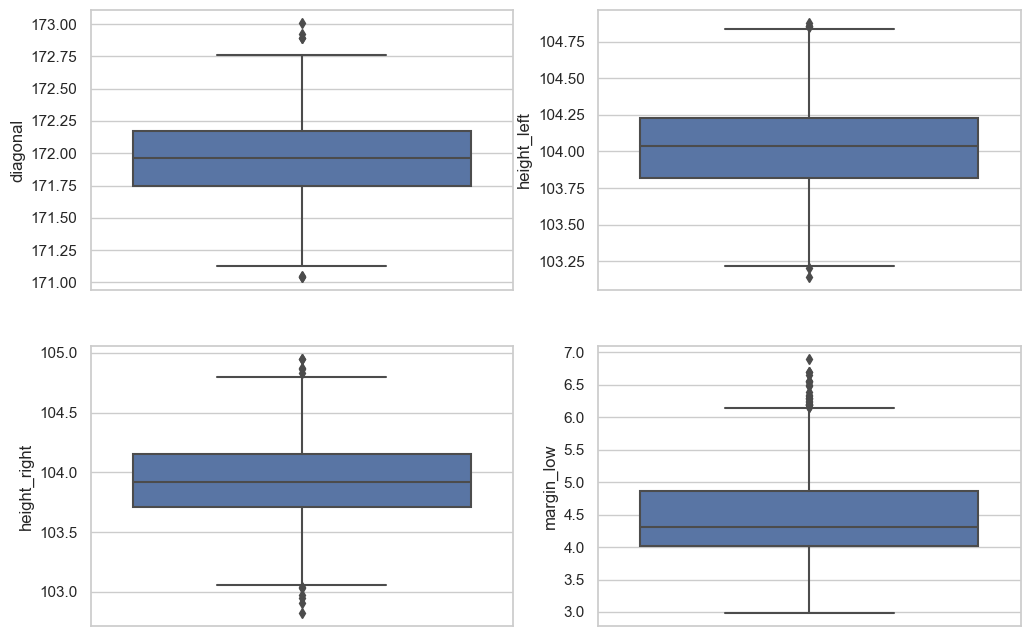

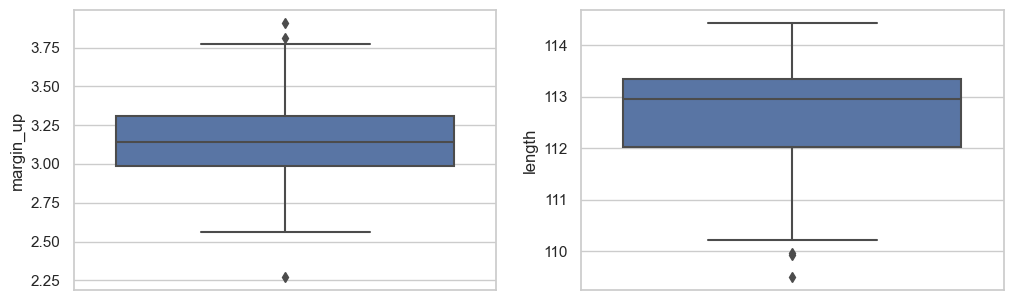

In [17]:
# Afficher des boxplot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,y='diagonal')
plt.subplot(222)
sns.boxplot(data=billets, y='height_left')
plt.subplot(223)
sns.boxplot(data=billets, y='height_right')
plt.subplot(224)
sns.boxplot(data=billets,y='margin_low')
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')
plt.subplot(222)
sns.boxplot(data=billets,  y='length')

Si la médiane change par rapport aux paramètre alors la variable est dépendante et ne suis pas une loi normale !

Les boites à moustaches confirment le pairplot, margin_low et lengh sont les variables qui discriminent le plus. 
On a des valeurs atypiques, ce qui peut peut-être s'expliquer par l'inégalité entre le nombre de vrai et faux villets (dispersion des billets par dimension).

## 3. Remplacement des billets manquants

Nous allons procéder au remplacement des valeurs manquantes de 'margin_low' par régression linéaire multiple. 
Pour ce faire, créons un modèle à partir de toutes les variables dont nous allons analyser la performance en vérifiant la colinéarité des variables, l'homoscédacité des résidus et la visualisation des résultats.
Puis nous allons prédire les valeurs de 'margin_low' à partir du modèle et remplacer uniquement les valeurs manquantes par les valeurs prédites.
Nous visualiserons l'impact des résultats sur la corrélation des variables et par paire de variable

In [18]:
# Separation des donnees de celles manquantes :

billet_test = billets[billets.isnull().any(axis=1)]
billet_test.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72            1    171.94       103.89        103.45         NaN       3.25   
99            1    171.93       104.07        104.18         NaN       3.14   
151           1    172.07       103.80        104.38         NaN       3.02   
197           1    171.45       103.66        103.80         NaN       3.62   
241           1    171.83       104.14        104.06         NaN       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36

In [19]:
billet_train = billets.dropna()
billet_train.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

On a des valeurs manquantes dans la colonne "Margin_low". Nous souhaitons pouvoir "prédire" ces données à l'aide d'un model de Machine Learning (model de Régression Linéaire).

## 3.1 Mise en place du modèle de régression linéaire

In [20]:
# Création de X_train et Y_train :

x_train = billet_train.drop('margin_low', axis = 1)
y_train = billet_train['margin_low']

# Régréssion linéaire :

reg_lin = LinearRegression()
model_reg_lin = reg_lin.fit(x_train, y_train)

# Prédictions :

x_train = billet_train[['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
billet_train['margin_low_pred'] = reg_lin.predict(x_train)

C:\Users\chthioub\AppData\Local\Temp\ipykernel_1768\4026193766.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billet_train['margin_low_pred'] = reg_lin.predict(x_train)


In [21]:
print("Intercept:", model_reg_lin.intercept_)
print("Coéfficients:", model_reg_lin.coef_)

Intercept: 2.866822892054323
Coéfficients: [-1.14059676 -0.0130159   0.02829069  0.02674982 -0.21284432 -0.00388299]


In [22]:
#Fonction de selection automatique du modele
def backward_selected(Full_data, response):
        remaining = set(Full_data._get_numeric_data().columns)
        if response in remaining:
            remaining.remove(response)
        cond = True
        while remaining and cond:
            formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
            print('_______________________________')
            print(formula)
            model = smf.ols(formula, Full_data).fit()
            score = model.pvalues[1:]
            toRemove = score[score == score.max()]
            if toRemove.values > 0.05:
                print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
                remaining.remove(toRemove.index[0])
            else:
                cond = False
                print('is the final model !')
            print('')
        print(model.summary())
        return model

## 3.2 Validation du modèle de régression

In [23]:
#validation du modéle :

reg_linb = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = billet_train)
res_lin = reg_linb.fit()
print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 21 Aug 2024   Prob (F-statistic):          2.60e-202
Time:                        20:56:31   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Prob(F-Statistic) est L'hypothèse nulle du test de Fisher est que tous les coefficients sont nuls (significativité du modèle global =/= t significativité pour les variables). 
Ici, elle est très faible et inférieure au seuil 5 %, on rejet l'hypothèse nulle, notre modèle est meilleur que celui où les coefficients seraient nuls.

    Le R² ajusté (puisque nous avons un grand nombre de valeurs) n'est pas satisfaisant (inférieur à 0,5). 
C'est la partie de la variation totale de la variable dépendante qui est expliquée par la variation de la variable indépendante.

    Les coefficients représentent le changement moyen de la variable de réponse pour une unité de changement dans la variable prédictive tout en maintenant d’autres prédicteurs dans le modèle constant. 
Ainsi ici, si la longueur ('length') change d'une unité (1 mm), l'estimation de "margin_low" diminuera de 0,4091 mm en moyenne.

## 3.3 TEST D'HYPOTHESE PAR ANALYSE DES RESIDUS

Il y a différente hypothèses à tester pour notre régression linéaire :

Normalité de la distribution des résidus : 

    Omnibus test, l'hypothèse nulle est que les résidus sont distribués selon une loi Normale. La valeur de Prob(Omnibus) doit être proche de 1. Ici elle est nulle ce qui implique que l'hypothèse n'est pas verifée, les coefficiants estimés ne seront pas BLUE. 
Prob(Jacque-Bera) est redondant avec Prob(Omnibus), une valeur élevée pour le Jarque-Bera indique que les résidus sont distribués selon une loi Normale. 
Pour lever le doute on effectue un test d'Aderson-Darling qui nous indique que les résidus suivent une distribution Normale.

Homocédasticité (c'est-à-dire la constance de la variance) des résidus: 

    les variances des résidus doivent être constantes, les tests de Breusch-Pagan et de White permettent de tester l'hypothèse d'homoscédasticité du terme d'erreur d'un modèle de régression linéaire. 
Le test de Breusch-Pagan ne fonctionne pas très bien pour les distributions non-normales et non-linéaires contrairement au test de White qui est en fait un cas particulier du Breusch-Pagan.

Non-autocorrélation : 

    l'autocorrélation est la corrélation des erreurs (résidus) dans le temps. Durbin-Watson < 1.5, autocorrélation positive, l'hypothèse n'est pas satisfaite. 1.5 < Durbin-Watson < 2.5 pas d'autocorrélation, l'hypothèse est satisfaite. Durbin-Watson > 2.5, autocorrélation négative, l'hypothèse n'est pas satisfaite.
Ici, il est de 1.893, il n'y a donc pas d'autocorrélation.

Multicollinéarité : 

    Supposont que les prédicteurs de la régression ne sont pas corrélés les uns aux autres.
Le cond. No. est élevée il semble qu'il y ai un problème de multicollinéarité.
Le VIF indique effectivment une forte multicolinéarité.

Linéarité :

    Partont de l'hypothèse qu'il existe une relation linéaire entre les variables indépendantes et la variable dépendante.
  
Si l'hypothèse de non-colinéarité n'est pas vérifiée, l'estimation du modèle est impossible alors que pour toutes les autres hypothèses l'estimation est possible, mais donne un estimateur non efficace.
Il existe des corrections possibles, la normalité des erreurs est non obligatoire, mais permet de tirer de bonnes propriétés.

In [24]:
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
reg_backward = backward_selected(billet_train[columns], 'margin_low')

_______________________________
margin_low ~ length + height_left + diagonal + margin_up + height_right + is_genuine + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ height_left + diagonal + margin_up + height_right + is_genuine + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ height_left + margin_up + height_right + is_genuine + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ height_left + margin_up + is_genuine + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

In [25]:
# Moyenne des residus 'nulle' : 
res_lin.resid.mean()

3.0116715683174174e-14

'3e-14' peut être considéré comme égale à zéro, de ce fait, l'hypothèse est validée.

## Multicollinéarité

In [26]:
# Multicollinéarité ('is_genuine' étant une variables qualitative, elle n'est pas utilisé) :

vif = pd.Series([variance_inflation_factor(billet_train[["diagonal","height_left","height_right", "margin_up", "length"]].values, i)
               for i in range(billet_train[["diagonal","height_left","height_right", "margin_up", "length"]].shape[1])],
              index = billet_train[["diagonal","height_left","height_right", "margin_up", "length"]].columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

VIF par features:
 diagonal        170566.670778
height_left     111895.309916
height_right    100858.864433
margin_up          261.969190
length           22708.222743
dtype: float64
VIF moyen: 81258.20741161003


## Linéarité 

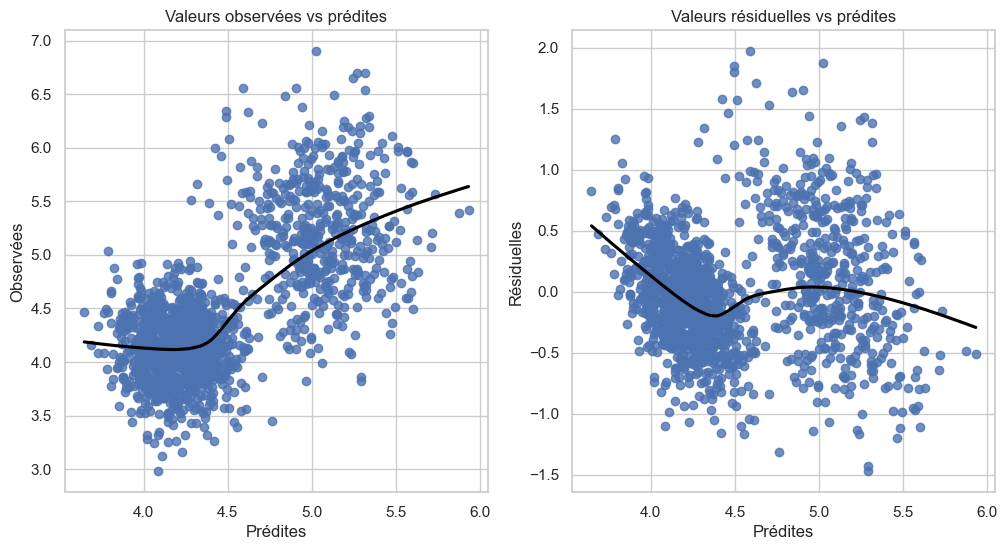

In [27]:
# Linéarité :

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1, 2, figsize = (12,6))
    
    sns.regplot(x = fitted_vals, y = y, lowess = True, ax = ax[0], line_kws = {'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel = "Prédites", ylabel = "Observées")

    sns.regplot(x = fitted_vals, y = resids, lowess = True, ax = ax[1], line_kws = {'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel = "Prédites", ylabel = "Résiduelles")
    
linearity_test(res_lin, billet_train['margin_low'])

La relation n'est pas linéaire, l'hypothèse de linéarité n'est pas vérifiée. 

    Solutions potentielles :

        Transformation non-linéaire sur les variables dépendantes/indépendantes.
        Ajout d'une feature, transformation de features préexistantes (mise au carré par exemple).
        Ajout de features non considérées précédemment.

In [28]:
# Création du champ 'residu':

billet_train['residu'] = billet_train['margin_low'] - billet_train['margin_low_pred']
billet_train.head()

C:\Users\chthioub\AppData\Local\Temp\ipykernel_1768\1380207972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billet_train['residu'] = billet_train['margin_low'] - billet_train['margin_low_pred']


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  margin_low_pred    residu  
0  112.83         4.210681  0.309319  
1  113.09         4.115999 -0.345999  
2  113.16         4.137766  0.262234  
3  113.51         4.134463 -0.514463  
4  112.54         4.031004  0.008996

### Normalité 

In [29]:
# Normalité :

print("P-value du test d'Aderson-Darling = ", normal_ad(billet_train['residu'])[1])

P-value du test d'Aderson-Darling =  3.9857722331535204e-05


In [30]:
# Graphique:

sns.histplot(billet_train['residu'], kde=True)
plt.xlabel("Résidu")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

Une P-value inférieure à alpha pour le test d'Anderson-Darling indique que l'hypothèse nulle de normalité de la distribution des résidus est rejetée.

Ici, l'hypothèse n'est pas rejetée puisque la P-value obtenue est inférieure au seuil de 5 %, les résidus suivent une distribution Normale.

### Homocédasticité 

In [31]:
# Homocédasticité :

white_test = het_white(res_lin.resid, res_lin.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

{'Test Statistic': 109.86015196878176, 'p-value': 2.0828244988746557e-14, 'F-Statistic': 5.853731207808184, 'F-Test p-value': 4.974865092433876e-15}


Text(0.5, 1.0, 'Homocédasticité')

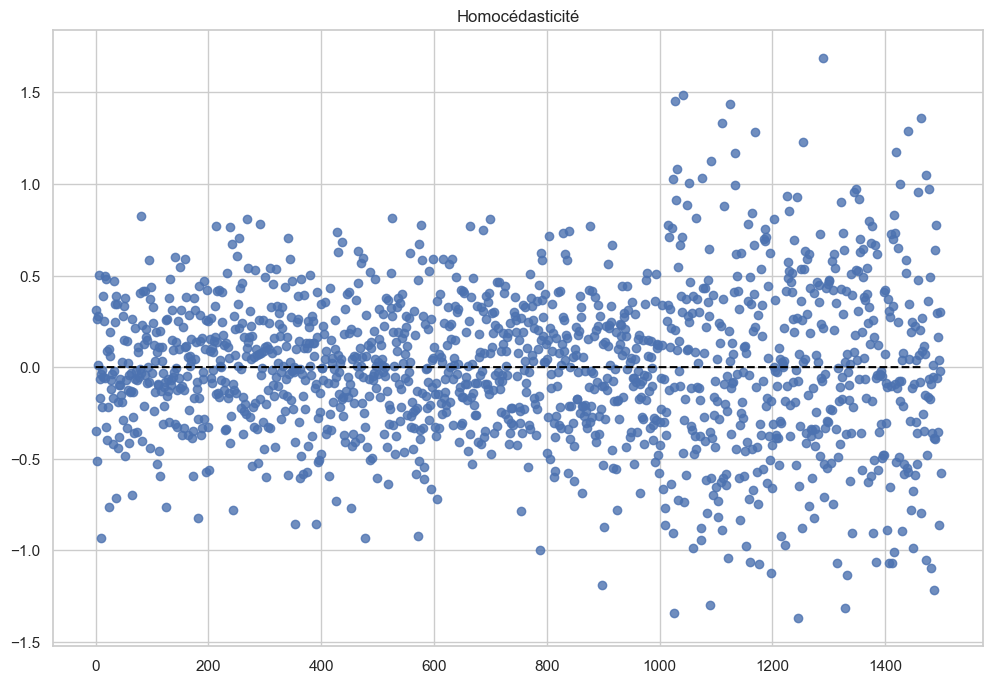

In [32]:
# Graphique :

plt.subplots(figsize = (12, 8))
plt.scatter(x = billet_train.index, y = billet_train['residu'], alpha = 0.8)
plt.plot(np.repeat(0, len(billet_train.index) + 2), color = "black", linestyle = '--')
plt.title("Homocédasticité")

La répartition semble aléatoire, l'hypothèse nulle du test de White est qu'il y à homoscédasticité (les résidus sont dispersés aléatoirement, la variance d'un individu à un autre est constante), l'hypothèse alternative est qu'il y a hétéroscédasticité.
On fixe une limite de 5 %.
La P-value est  inférieure la limite fixée, on ne peut pas rejeter l'hypothèse nulle d'homoscédasticité. L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée à la limite 5 %.

## Identification des individus atypiques

Text(0, 0.5, 'Résidus studentisés')

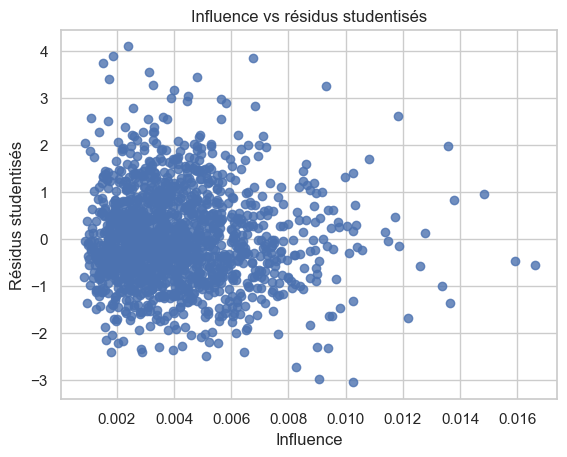

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Identification des individus atypiques :

student_resid = res_lin.get_influence().resid_studentized_external
(cooks, p_val_cooks) = res_lin.get_influence().cooks_distance
(dffits, p_val_dffits) = res_lin.get_influence().dffits
leverage = res_lin.get_influence().hat_matrix_diag

# Graphique :

sns.regplot(x=leverage, y=res_lin.resid_pearson, fit_reg = False)
plt.title("Influence vs résidus studentisés")
plt.xlabel("Influence")
plt.ylabel("Résidus studentisés")

In [34]:
# Création d'un dataframe de travail :

billet_atypique = pd.concat([billet_train["margin_low"], res_lin.get_influence().summary_frame()], axis = 1)
billet_atypique = billet_atypique.rename(columns = {"hat_diag": "leverage"})
billet_atypique.head()

margin_low  dfb_Intercept  dfb_diagonal  dfb_height_left  dfb_height_right  \
0        4.52       0.038028      0.011150        -0.040676         -0.050650   
1        3.77      -0.047734      0.031782         0.040802          0.006819   
2        4.40      -0.028752      0.034142         0.027975         -0.020340   
3        3.62      -0.031981      0.060924         0.001406         -0.016400   
4        4.04      -0.025618      0.021411        -0.027128          0.056039   

   dfb_margin_up  dfb_length   cooks_d  standard_resid  leverage  \
0       0.028339   -0.018016  0.000894       -0.563593  0.016606   
1       0.006051    0.006096  0.000597       -0.769710  0.006015   
2      -0.010975   -0.001295  0.000457        0.572488  0.008298   
3       0.006425   -0.029579  0.000936       -1.118681  0.004467   
4      -0.049448   -0.009670  0.001171       -1.121058  0.005558   

   dffits_internal  student_resid    dffits  
0        -0.073239      -0.563461 -0.073221  
1        -0.059874      -0.769603 -0.059866  
2         0.052367       0.572356  0.052355  
3        -0.074934      -1.118778 -0.074940  
4        -0.083813      -1.121157 -0.083821

'influence.resid_studentized_external' : Résidus studentisés en externe, permettent de détecter les valeurs aberrantes, observations qui possèdent des valeurs extrêmes sur l'ensemble des prédicteurs ou la variable dépendante.

'influence.cooks_distance' : Distance de Cook, utilisée pour estimer l'influence d'une donnée lors de l'utilisation de méthodes des moindres carrés.

'influence.dffits' : DFFITS statistics ("difference in fit(s)"), c'est une méthode de diagnostique de l'influence d'un point dans une régression.

'influence.hat_matrix_diag' : La diagonale de projection, ou "hat". La mtatrice hat décrit l'influence de chaque valeur dépendante sur chaque valeur estimée. Sa diagonale correspond aux 'leverages', qui décrivent l'influence de chaque valeur sur l'estimation pour la même observation.

In [35]:
# Studentisation des residus :

residu_stud = billet_atypique.student_resid
print ("résidus studentisés:\n", residu_stud.describe())

# Individus atypiques :

atypique = pd.DataFrame((billet_atypique["margin_low"][abs(residu_stud) > 2]))
print(atypique.count())

résidus studentisés:
 count    1463.000000
mean        0.000133
std         1.001419
min        -3.087577
25%        -0.660578
50%        -0.086814
75%         0.570403
max         4.127099
Name: student_resid, dtype: float64
margin_low    72
dtype: int64


Ont constate 72 individus atypiques (résidus studentisés > 2 en valeur absolue), il faut maintenant, supprimer les atypique que s'ils sont influents. L'influence se situe au-dessus du seuil (2*k) +2/n avec k = nombre de variables explicatives et n = nombre d'observations.

### Identification des individus a forte influence :

In [36]:
# Identification des individus a forte influence :

k_reg_lin = 5          # k = nombre de variables predictives pour la regression lineaire +1 si on a une constante
n_reg_lin = 1500       # n = nombre d'observations
lev_thr = ((2*k_reg_lin)+2)/n_reg_lin          #=0.047 Seuil (threshold), toutes valeurs au dessus aura une forte influence

print(billet_atypique["leverage"].describe())

hg_leverage = billet_atypique["margin_low"][abs(billet_atypique["leverage"]) > lev_thr]
print("nombre d'individus à forte influence:", hg_leverage.count())

count    1463.000000
mean        0.004101
std         0.002134
min         0.000840
25%         0.002561
50%         0.003645
75%         0.005140
max         0.016606
Name: leverage, dtype: float64
nombre d'individus à forte influence: 79


Il y a donc 79 individus influents.
Il faut maintenant les regrouper  pour identifier les individus ayant un impact sur la régression linéaire.

### individus atypiques à forte influence

In [37]:
# Identification des individus atypiques à forte influence :

outliers_hg_lev =pd.merge(atypique,hg_leverage, left_index=True, right_index=True)
print(outliers_hg_lev.count())
print(outliers_hg_lev)

margin_low_x    7
margin_low_y    7
dtype: int64
      margin_low_x  margin_low_y
664           5.04          5.04
965           3.45          3.45
1074          4.36          4.36
1089          3.86          3.86
1199          4.49          4.49
1329          3.82          3.82
1478          6.08          6.08


## Suppression des individus atypiques et influent

In [38]:
# Suppression des individus atypiques et influent :

billet_sans_atypique = billets.drop(outliers_hg_lev.index)
reg_lin_c = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = billet_sans_atypique)
model_reg_lin_b = reg_lin_c.fit()
print(model_reg_lin_b.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     282.2
Date:                Wed, 21 Aug 2024   Prob (F-statistic):          5.39e-211
Time:                        20:56:52   Log-Likelihood:                -972.21
No. Observations:                1456   AIC:                             1956.
Df Residuals:                    1450   BIC:                             1988.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.2866      9.516      2.552   

Les changement sont : 
        Le R² (ajusté ou non) augmente légèrement (0.47 à 0.49).
        La F-stat passe de 1174 à 282.2 avec un changement d'ordre de grandeur de la Prob de -202 à -211.
        L'AIC passe de 2015 à 1956.
        Le BIC de 2046 à 1998.
        Le log diminue de -774.73 à -972.21.
        
Au final, le nombre d'individus dit 'influents' et 'atypiques' est faible, et n'influencent finalement que très peu sur le DataFrame.
La conclusion et que la suppression de ces données n'est pas pertinante. 
Il sera toujours possible d'utiliser, 'billet_sans_atypique' à la place de 'billet' si l'analyse le demande.

## Application du modèle sur les données test 

In [39]:
# Application du modèle sur les données test : 

x_test = billet_test[['is_genuine','diagonal','height_left','height_right', 'margin_up', 'length']]
billet_test['margin_low'] = reg_lin.predict(x_test)

# Concaténation :

reg_lin_result = [billet_test, billet_train]
billet_final = pd.concat(reg_lin_result)
billet_final.head()

C:\Users\chthioub\AppData\Local\Temp\ipykernel_1768\3759566986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billet_test['margin_low'] = reg_lin.predict(x_test)


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72            1    171.94       103.89        103.45    4.064954       3.25   
99            1    171.93       104.07        104.18    4.111990       3.14   
151           1    172.07       103.80        104.38    4.134003       3.02   
197           1    171.45       103.66        103.80    3.993571       3.62   
241           1    171.83       104.14        104.06    4.140399       3.02   

     length  margin_low_pred  residu  
72   112.79              NaN     NaN  
99   113.08              NaN     NaN  
151  112.93              NaN     NaN  
197  113.27              NaN     NaN  
241  112.36              NaN     NaN

### Dataframe de travail 

In [40]:
billet_final = billet_final.drop(['margin_low_pred', 'residu'], axis = 1)
billet_final.info()
billet_final.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 72 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 93.8 KB


is_genuine     diagonal  height_left  height_right   margin_low  \
count  1500.000000  1500.000000  1500.000000   1500.000000  1500.000000   
mean      0.666667   171.958440   104.029533    103.920307     4.482844   
std       0.471562     0.305195     0.299462      0.325627     0.659899   
min       0.000000   171.040000   103.140000    102.820000     2.980000   
25%       0.000000   171.750000   103.820000    103.710000     4.027500   
50%       1.000000   171.960000   104.040000    103.920000     4.310000   
75%       1.000000   172.170000   104.230000    104.150000     4.870000   
max       1.000000   173.010000   104.880000    104.950000     6.900000   

         margin_up      length  
count  1500.000000  1500.00000  
mean      3.151473   112.67850  
std       0.231813     0.87273  
min       2.270000   109.49000  
25%       2.990000   112.03000  
50%       3.140000   112.96000  
75%       3.310000   113.34000  
max       3.910000   114.44000

Il n'y a plus de valeurs manquantes et très peu de changement au niveau des infos.

Text(0.5, 1.0, 'Boîtes à moustaches')

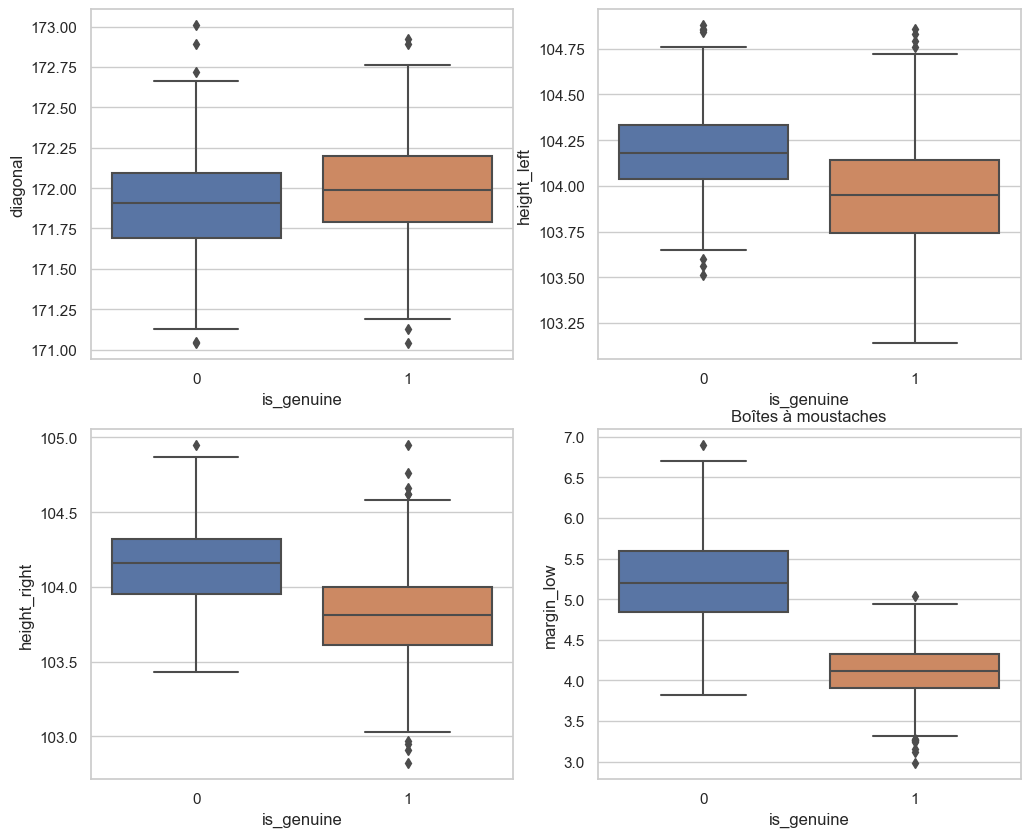

In [41]:
# Affichage des boxplot : 

plt.figure(figsize = (12, 10))
sns.set(style = "whitegrid")
plt.subplot(221)
sns.boxplot(x = "is_genuine", y = "diagonal", data = billet_final)
plt.subplot(222)
sns.boxplot(x = "is_genuine", y = "height_left", data = billet_final)
plt.subplot(223)
sns.boxplot(x = "is_genuine", y = "height_right", data = billet_final)
plt.subplot(224)
sns.boxplot(x = "is_genuine", y = "margin_low", data = billet_final)
plt.title('Boîtes à moustaches')

<Axes: xlabel='is_genuine', ylabel='length'>

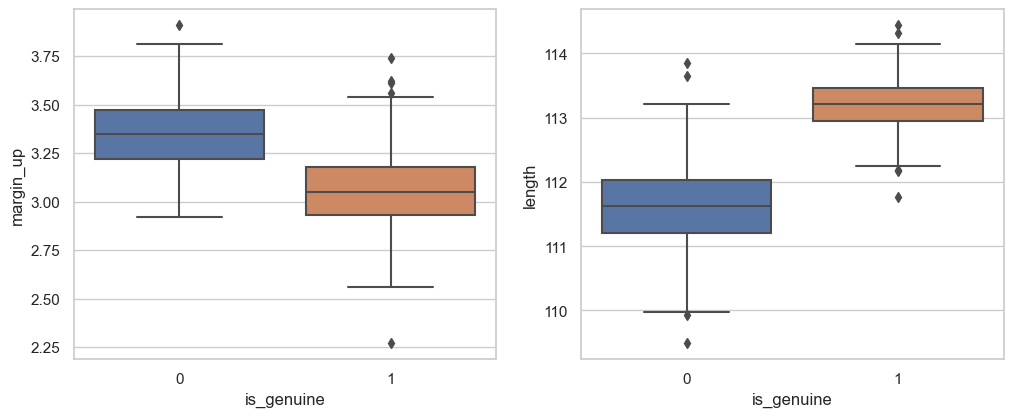

In [42]:
plt.figure(figsize = (12, 10))
sns.set(style = "whitegrid")
plt.subplot(221)
sns.boxplot(x = "is_genuine", y = "margin_up", data = billet_final)
plt.subplot(222)
sns.boxplot(x = "is_genuine", y = "length", data = billet_final)

Les box plot indiquent une différence de variances assez nette entre vrais et faux billets concernant chaque variable.
On constate néanmoins qu'elle est moindre pour la variable 'diagonal'

In [43]:
# Identification des individus :

q1 = billet_final.loc[:, billet_final.columns != "is_genuine"].quantile(q=0.25, interpolation="midpoint")
q3 = billet_final.loc[:, billet_final.columns != "is_genuine"].quantile(q=0.75, interpolation="midpoint")
iq = q3 - q1

lim_inf = q1 - 1.5 * iq
lim_sup = q3 + 1.5 * iq

In [44]:
billet_final.describe()

is_genuine     diagonal  height_left  height_right   margin_low  \
count  1500.000000  1500.000000  1500.000000   1500.000000  1500.000000   
mean      0.666667   171.958440   104.029533    103.920307     4.482844   
std       0.471562     0.305195     0.299462      0.325627     0.659899   
min       0.000000   171.040000   103.140000    102.820000     2.980000   
25%       0.000000   171.750000   103.820000    103.710000     4.027500   
50%       1.000000   171.960000   104.040000    103.920000     4.310000   
75%       1.000000   172.170000   104.230000    104.150000     4.870000   
max       1.000000   173.010000   104.880000    104.950000     6.900000   

         margin_up      length  
count  1500.000000  1500.00000  
mean      3.151473   112.67850  
std       0.231813     0.87273  
min       2.270000   109.49000  
25%       2.990000   112.03000  
50%       3.140000   112.96000  
75%       3.310000   113.34000  
max       3.910000   114.44000

Pour un modele capable de prédire si un billet est vrai ou faux, nous allons tester plusieurs 2 méthodes :
- LogisticRegression
- K-Means

## 4. Régression logistique

## 4.1 Mise en place du modèle

In [45]:
# y (authenticite): 
y_billet = billet_final.loc[:, billet_final.columns == "is_genuine"]
#Comptage des modalites de y
print(y_billet.value_counts())                                  

is_genuine
1             1000
0              500
Name: count, dtype: int64


In [46]:
# X (les autres):
X_billet = billet_final.loc[:, billet_final.columns != "is_genuine"]
#ajouter d'une constante dans Statsmodels
X_billet = sm.tools.add_constant(X_billet)                      

In [47]:
print(X_billet.head())

     const  diagonal  height_left  height_right  margin_low  margin_up  length
72     1.0    171.94       103.89        103.45    4.064954       3.25  112.79
99     1.0    171.93       104.07        104.18    4.111990       3.14  113.08
151    1.0    172.07       103.80        104.38    4.134003       3.02  112.93
197    1.0    171.45       103.66        103.80    3.993571       3.62  113.27
241    1.0    171.83       104.14        104.06    4.140399       3.02  112.36


## Le modèle de Regression logistique

In [48]:
# Regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.026349
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Wed, 21 Aug 2024   Pseudo R-squ.:                  0.9586
Time:                        20:56:55   Log-Likelihood:                -39.524
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -230.4143    249.954     -0.922      0.357    -720.316     259.487
diagonal         0.256

- Pseudo R-Square à 0.9586 : le model explique une grande partie de la variation dans la variable de réponse "is_genuine".
- I
 Iterations 13
- Des variables x non-significatives au seuil alpha 5 % (si on prend alpha 1 %, on enlèvera height_right en plus), on recommence la régression sans ces variables (diagonal, height_left, height_right).

In [49]:
# On garde que les variables significatives à alpha (= 5%) dans X_Billet:
X_billet = billet_final[["height_right","margin_low", "margin_up", "length"]]
X_billet = sm.add_constant(X_billet)

## seconde regression logistique après sélection

In [50]:
# seconde regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

In [51]:
# Creation du modèle:
model_reg_log = reg_log.fit()

# Resume des resultats:
print(model_reg_log.summary2())

Optimization terminated successfully.
         Current function value: 0.026815
         Iterations 13
                         Results: Logit
Model:                Logit            Method:           MLE     
Dependent Variable:   is_genuine       Pseudo R-squared: 0.958   
Date:                 2024-08-21 20:56 AIC:              90.4453 
No. Observations:     1500             BIC:              117.0114
Df Model:             4                Log-Likelihood:   -40.223 
Df Residuals:         1495             LL-Null:          -954.77 
Converged:            1.0000           LLR p-value:      0.0000  
No. Iterations:       13.0000          Scale:            1.0000  
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -285.3339 139.1600 -2.0504 0.0403 -558.0825 -12.5852
height_right   -3.3223   1.1166 -2.9752 0.0029   -5.5109  -1.1337

- LLR p-value < 0.05 => le modèle est significatif dans son ensemble.
- Le pseudo R² très proche de 1, notre modèle explique donc la majorité de la variance observée.

Les coefficients : 
l'interprétation des coefficients estimés dépend de la fonction de liaison, de l'événement de référence et des niveaux de facteur de référence. 
Une estimation de coefficient associée à un prédicteur (facteur ou covariable) représente la variation de la fonction de liaison ln(μi/(1−μi)) pour chaque variation d'unité du prédicteur, tous les autres prédicteurs étant maintenus constants. 

Pour la fonction de liaison logit, le logarithme népérien des probabilités de succès est fonction des coefficients estimés: ln [P(événement)/P(non événement)] = β0 + β1x1 + β2x2 + ... + βnxn Plus le logarithme des probabilités de succès est important, plus l'événement de référence est probable. 1/Des coefficients positifs indiquent que la probabilité de l'événement augmente, 
2/Des coefficients négatifs indiquent qu'elle diminue. 


## Tests d'hypothèses

Lorsque l'on fait une régression logistique, on fait plusieurs hypothèses :

- La taille de l'échantillon doit être suffisante, ici > 1000. 
En règle générale, on souhaite avoir plus de 500 observations indépendantes et plus de 20 observations pour l'outcome la moins fréquente. 
C'est le cas ici puisque nous avons 1500 observations dont 500 faux billets.

- significativité des variables : 
seules les variables significatives sont incluses, on doit donc enlever les autres (suppression des variables dont la p-value était inférieure au seuil/ p-value du test de Wald: Les variables <  0,05 (seuil).

- Indépendance des observations : 
les observations sont indépendantes : chaque billets est uniques et indépendants des autres.

- Binaire : 
La régression logistique binaire nécessite que la variable dépendante soit binaire. 
'is_genuine' ne peut prendre que deux valeurs, l'hypothèse est vérifiée. 

- Multicollinéarité : minimale ou nulle entre les varaibles indépendantes. Test avec VIF (variance inflation factor)

- Linéarité avec les log-odds : les variables indépendantes ont une relation linéaire avec les log-odds. 

- Test Box-Tidwell : Cette hypothèse n'est pas vérifiée ici.

- Pas d'outliers : individus influents aberrants. Se vérifie avec l'IQR, du z-score ou peut être visualisé à l'aide de graphiques en boîte ou en violon.

### a/Test de Wald

In [52]:
print("av élimination des variables non-significatives:\n", res_log.wald_test_terms())
print("ap élimination des variables non-significatives:\n", model_reg_log.wald_test_terms())

av élimination des variables non-significatives:
                                 chi2                 P>chi2  df constraint
const         [[0.8497621257815331]]     0.3566196399327337              1
diagonal      [[0.0509200955547861]]     0.8214699039722553              1
height_left   [[1.3215862655555237]]    0.25030756394986775              1
height_right  [[6.4146639953338145]]   0.011318174203538721              1
margin_low     [[37.19905305068305]]  1.066655631933279e-09              1
margin_up      [[21.79739115608416]]  3.030118679814722e-06              1
length         [[45.57831447867373]]  1.466562797997077e-11              1
ap élimination des variables non-significatives:
                                 chi2                  P>chi2  df constraint
const           [[4.20414399128427]]     0.04032532210128999              1
height_right   [[8.852048419167959]]   0.0029276014836577794              1
margin_low     [[42.86750384793732]]   5.857562437473779e-11            

C:\Users\chthioub\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\chthioub\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


On garde que les variables significatives.

### b/Test binarite:

In [53]:
# Test binarite:
print(billet_final["is_genuine"].nunique())

2


### c/Test Box-Tidwell

In [54]:
# Test Box-Tidwell: (Les autres variable ne sont pas dans le modele)
var_cont = ["height_right","margin_low","margin_up","length"]                                    

# On ajoute les variables transformées (logarithme neprien):
for var in var_cont:
    billet_final[f'{var}:log_{var}'] = billet_final[var].apply(lambda x: x * np.log(x))

# On ne garde que les colonnes qui concernent les variables continues:
cols_to_keep = var_cont + billet_final.columns.tolist()[-len(var_cont):]

# On intègre des ln dans les variables:
X_lt = billet_final[cols_to_keep]
X_lt = sm.add_constant(X_lt, prepend=False)
y_lt = billet_final["is_genuine"]

# Construction du modele:
logit_results = GLM(y_lt, X_lt).fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1491
Model Family:                Gaussian   Df Model:                            8
Link Function:               Identity   Scale:                        0.035251
Method:                          IRLS   Log-Likelihood:                 385.05
Date:                Wed, 21 Aug 2024   Deviance:                       52.560
Time:                        20:57:00   Pearson chi2:                     52.6
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9951
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
height_right  

### d/Multicollinearite:

In [55]:
# Multicollinearite:
vif= pd.Series([variance_inflation_factor(X_billet.values, i)
               for i in range(X_billet.shape[1])],
              index=X_billet.columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

VIF par features:
 const           185267.941418
height_right         1.245903
margin_low           1.890373
margin_up            1.410219
length               2.109374
dtype: float64
VIF moyen: 37054.91945740548


Tous les VIF dees varibles sont < 5=> pas de collinéarité !

In [56]:
# On ne garde que les variables qui passent le test Box-Tidewell:
X_billet_a = billet_final[["height_right","margin_low"]]
X_billet_a = sm.add_constant(X_billet_a)

## 3ème regression logistique

In [57]:
# On recommence la regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet_a)

In [58]:
## 4.2 Creation du modele

In [59]:
# Création du modèle:
model_reg_log_a = reg_log.fit()

# Résume des résultats:
print(model_reg_log_a.summary2())

Optimization terminated successfully.
         Current function value: 0.179318
         Iterations 9
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: is_genuine       Pseudo R-squared: 0.718      
Date:               2024-08-21 20:57 AIC:              543.9536   
No. Observations:   1500             BIC:              559.8932   
Df Model:           2                Log-Likelihood:   -268.98    
Df Residuals:       1497             LL-Null:          -954.77    
Converged:          1.0000           LLR p-value:      1.4563e-298
No. Iterations:     9.0000           Scale:            1.0000     
------------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
------------------------------------------------------------------
const          414.2970  44.2654   9.3594 0.0000 327.5385 501.0556
height_right    -3.7018   0.4214  -8.7848 0.0000  -4.

Diagnostique des résidus

In [60]:
print(dir(model_reg_log))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_data_attr', '_data_in_cache', '_get_endog_name', '_get_robustcov_results', '_get_wald_nonlinear', '_transform_predict_exog', '_use_t', 'aic', 'bic', 'bse', 'conf_int', 'converged', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'f_test', 'fittedvalues', 'get_distribution', 'get_influence', 'get_margeff', 'get_prediction', 'im_ratio', 'info_criteria', 'initialize', 'k_constant', 'llf', 'llnull', 'llr', 'llr_pvalue', 'load', 'method', 'mle_retvals', 'mle_settings', 'model', 'nobs', 'normalized_cov_params', 'params', 'pred_table', 'predict', 'prsquared', 'pvalues', 'remove_data', 'resid_dev', 'resid_generali

In [61]:
print(dir(reg_log))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_kwargs', '_check_perfect_pred', '_check_rank', '_continuous_ok', '_data_attr', '_deriv_mean_dparams', '_deriv_score_obs_dendog', '_derivative_exog', '_derivative_exog_helper', '_derivative_predict', '_fit_collinear', '_fit_zeros', '_formula_max_endog', '_get_init_kwds', '_handle_data', '_init_keys', '_kwargs_allowed', 'cdf', 'cov_params_func_l1', 'data', 'df_model', 'df_resid', 'endog', 'endog_names', 'exog', 'exog_names', 'family', 'fit', 'fit_constrained', 'fit_regularized', 'from_formula', 'get_distribution', 'hessian', 'hessian_factor', 'information', 'initialize', 'k_constant', 'k_extra', 'link', 'loglike', 'loglikeobs

## 4.3 Validation du modèle

In [62]:
# Suppression des colonnes inutiles:
Billets_data = billet_final.drop(["margin_low:log_margin_low","height_right:log_height_right","margin_up:log_margin_up","length:log_length"], axis=1)

In [63]:
# Application du modèle sur données d'entrainent :
Billets_data["proba"] = model_reg_log.predict(X_billet)
Billets_data["y_pred"] = (model_reg_log.predict(X_billet) >= 0.5).astype(int)
Billets_data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72            1    171.94       103.89        103.45    4.064954       3.25   
99            1    171.93       104.07        104.18    4.111990       3.14   
151           1    172.07       103.80        104.38    4.134003       3.02   
197           1    171.45       103.66        103.80    3.993571       3.62   
241           1    171.83       104.14        104.06    4.140399       3.02   

     length     proba  y_pred  
72   112.79  0.997694       1  
99   113.08  0.998127       1  
151  112.93  0.996980       1  
197  113.27  0.988619       1  
241  112.36  0.964849       1

## 4.4 Test du modèle

### a/Matrice de confusion

[[32.8         0.53333333]
 [ 0.2        66.46666667]]


Text(0.5, 1.0, 'Matrice de confusion de la régression logistique\n')

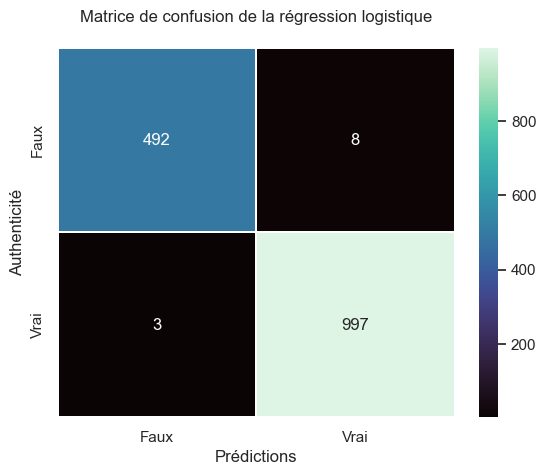

In [64]:
# Matrice de confusion:
conf_matrix_reg_log = model_reg_log.pred_table()
prct = (conf_matrix_reg_log*100)/n_reg_lin
print(prct)

# Graphique:
sns.heatmap(conf_matrix_reg_log,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique\n")

Interprétation de la matrice de confusion : 

Parmi les 1000 vrais billets :
997 ont été bien placés (vrais billets)
8 ont été prédis comme étant faux alors qu'ils étaient vrai (faux négatifs)

Parmi les 500 faux billets :
492 sont biens placés (faux billets)
3 sont prédis comme étant vrais alors qu'ils sont faux en réalité (faux positifs)

In [65]:
print("Précision:",accuracy_score(Billets_data["is_genuine"], Billets_data["y_pred"]))
print("Spécificité:",precision_score(Billets_data["is_genuine"], Billets_data["y_pred"]))
print("Sensibilité:",recall_score(Billets_data["is_genuine"], Billets_data["y_pred"]))
print("Score F1:",recall_score(Billets_data["is_genuine"], Billets_data["y_pred"]))

Précision: 0.9926666666666667
Spécificité: 0.9920398009950249
Sensibilité: 0.997
Score F1: 0.997


Le modèle est assez précis car tous les scores s'approchent de 1. 

- Accuracy : (précision) ratio de prédictions justes. C'est une bonne mesure si le jeu de données est symétrique et si les faux positifs et faux négatifs ont la même importance/le même poids. 
Accuracy = TP+TN/total

- Precision : (spécificité) ratio de vrais positifs sur le total des prédictions positives. Precision = TP/TP+FP

- Recall : (sensibilité) - Le ratio de positif prédit correctement parmi tous les positifs. Recall = TP/TP+FN

F1 score - Est une moyenne pondérée de la sensibilité et de la spécificité. 
On prend donc en compte les faux positifs et les faux négatifs en compte. 
Ce score, bien que moins intuitif que la précision est plus juste en particuliers pour les jeux de données dissymétriques. 
F1 Score = 2*(Recall * Precision)/(Recall + Precision)

In [66]:
# Odds Ratios (rem. utile pour parler en terme de risque):
print("Les Odds ratio sont:\n", np.exp(model_reg_log.params))

Les Odds ratio sont:
 const           1.205234e-124
height_right     3.607037e-02
margin_low       1.821674e-03
margin_up        3.035124e-05
length           4.724142e+02
dtype: float64


## b/Courbe R.O.C.

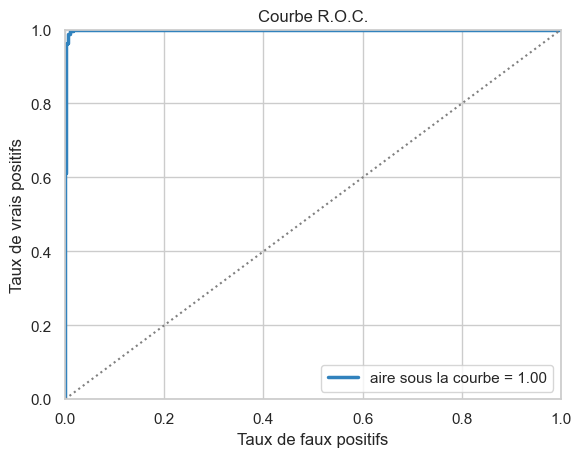

In [67]:
fpr, tpr, _ = roc_curve(Billets_data["is_genuine"],Billets_data["proba"])
roc_auc = roc_auc_score(Billets_data["is_genuine"],Billets_data["proba"])

# Graphique:
plt.title("Courbe R.O.C.")
plt.plot(fpr,
        tpr,
        color="#3182bd",
        linewidth=2.5,
        label="aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1],color="grey", linestyle=":")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = "lower right")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

## 4.5 Application du modèle aux données test

In [68]:
# Prédiction sur des données Test non connues initialement:
X_test = Billets_test_df[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
Billets_test_df["proba"] = model_reg_log.predict(X_test)
Billets_test_df["y_pred"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(Billets_test_df[["id","proba","y_pred"]])

    id     proba  y_pred
0  A_1  0.000030       0
1  A_2  0.000002       0
2  A_3  0.000010       0
3  A_4  0.996169       1
4  A_5  0.999993       1


In [69]:
# Affichage des résultats:
print("\nIndetification des billets:")
for i, k in zip(Billets_test_df["y_pred"],Billets_test_df["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")


Indetification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


## 5. Kmeans

In [70]:
# Création du df X : 
X = billet_final.set_index(['is_genuine'])
X

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                               
1             171.94       103.89        103.45    4.064954       3.25   
1             171.93       104.07        104.18    4.111990       3.14   
1             172.07       103.80        104.38    4.134003       3.02   
1             171.45       103.66        103.80    3.993571       3.62   
1             171.83       104.14        104.06    4.140399       3.02   
...              ...          ...           ...         ...        ...   
0             171.75       104.38        104.17    4.420000       3.09   
0             172.19       104.63        104.44    5.270000       3.37   
0             171.80       104.01        104.12    5.510000       3.36   
0             172.06       104.28        104.06    5.170000       3.46   
0             171.47       104.15        103.82    4.630000       3.37   

            length  height_right:log_height_right  margin_low:log_margin_low  \
is_genuine                                                                     
1           112.79                     479.913695                   5.700700   
1           113.08                     484.032800                   5.813972   
1           112.93                     485.162215                   5.867169   
1           113.27                     481.887968                   5.529841   
1           112.36                     483.355334                   5.882647   
...            ...                            ...                        ...   
0           111.28                     483.976339                   6.568737   
0           110.97                     485.501115                   8.758900   
0           111.95                     483.694050                   9.403171   
0           112.25                     483.355334                   8.493652   
0           112.07                     482.000819                   7.095738   

            margin_up:log_margin_up  length:log_length  
is_genuine                                              
1                          3.830629         532.992267  
1                          3.592860         534.653043  
1                          3.337876         533.793928  
1                          4.657036         535.741541  
1                          3.337876         530.531111  
...                             ...                ...  
0                          3.486049         524.356874  
0                          4.094256         522.586570  
0                          4.072122         528.185960  
0                          4.294789         529.901777  
0                          4.094256         528.872190  

[1500 rows x 10 columns]

In [71]:
# Centrage / réduction des données pour que nos données puissent prendre la même importance : 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
X_scaler

array([[-0.06044051, -0.46610259, -1.44479235, ..., -0.63568755,
         0.41047568,  0.12720668],
       [-0.09321736,  0.13517643,  0.79778359, ..., -0.56849768,
        -0.06646091,  0.45992513],
       [ 0.36565855, -0.76674211,  1.41218796, ..., -0.53694317,
        -0.57792838,  0.28781076],
       ...,
       [-0.51931643, -0.06524991,  0.61346228, ...,  1.5605159 ,
         0.89488175, -0.83568517],
       [ 0.3328817 ,  0.83666863,  0.42914097, ...,  1.02101416,
         1.34152653, -0.49193969],
       [-1.6009525 ,  0.40241156, -0.30814427, ...,  0.19181044,
         0.93928047, -0.69820628]])

 ## 5.1 Détermination du nombre de voisin(cluster) idéal

In [72]:
# Calcul des composantes principales : 

pca = PCA(n_components = 10)
pca.fit(X_scaler)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_)

[4.93484235e-01 1.43218634e-01 1.18787817e-01 9.94544332e-02
 8.11218554e-02 6.38534544e-02 5.45714329e-05 2.49676855e-05
 2.41667670e-08 7.48200176e-09]
[4.93813444e+00 1.43314177e+00 1.18867062e+00 9.95207804e-01
 8.11759727e-01 6.38960518e-01 5.46078381e-04 2.49843417e-04
 2.41828889e-07 7.48699309e-08]


In [73]:
# Définition de la fonction pour le graphique Éboulis des valeurs propres : 

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie(%)")
    plt.title("Éboulis des valeurs propres")
    plt.show(block=False)

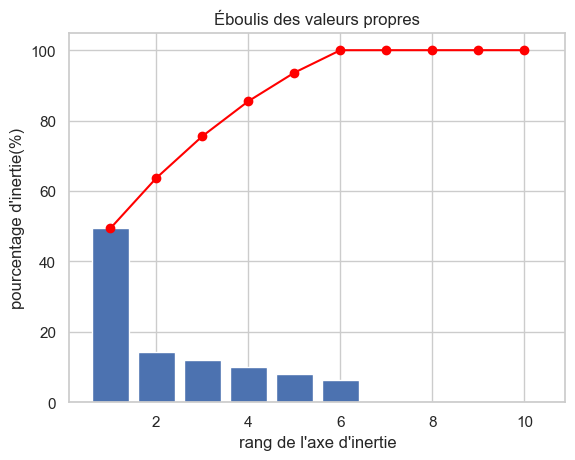

In [74]:
# Affichage d'un graphique 'Eboulis des valeur propres' : 

display_scree_plot(pca)

In [75]:
# Calcul de la variance et de la variance cumulée pour chaque dimenssion : 

variance = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(10)], 
        "Variance" : pca.explained_variance_,
        "% variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. variance" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
variance

Dimension      Variance  % variance  % cum. variance
0      Dim1  4.938134e+00        49.0             49.0
1      Dim2  1.433142e+00        14.0             64.0
2      Dim3  1.188671e+00        12.0             76.0
3      Dim4  9.952078e-01        10.0             85.0
4      Dim5  8.117597e-01         8.0             94.0
5      Dim6  6.389605e-01         6.0            100.0
6      Dim7  5.460784e-04         0.0            100.0
7      Dim8  2.498434e-04         0.0            100.0
8      Dim9  2.418289e-07         0.0            100.0
9     Dim10  7.486993e-08         0.0            100.0

On va choisir 2 composantes principales, car les 2 premières dimensions représentent 64% des informations importantes.

In [76]:
def plot_dendrogram(Z, names, figsize=(15,30)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
        leaf_font_size=12,
    )

In [77]:
# Clustering hiérarchique : 

from scipy.cluster.hierarchy import linkage
Z = linkage(X_scaler, 'ward')
names = X.index

# Affichage du dendrogramme : 

from scipy.cluster.hierarchy import dendrogram
plot_dendrogram(Z, names,figsize=(20,30))

#### On constate grace aux dendogramme que les observations sont réparties en deux cluster.

## 5.2 Mise en place du modèle

In [78]:
# Nombre de clusters:
n_clust = 2

# Clustering par K-means:
km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(Billets_data[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

C:\Users\chthioub\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [79]:
# Ajout d'une colonne contenant le cluster attribue:
clusters_km = km.labels_
Billets_data["cluster_km"] = km.labels_
Billets_data["cluster_km"] = Billets_data["cluster_km"].apply(str)

centroids_km = km.cluster_centers_

In [80]:
# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=3).fit(Billets_data[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(Billets_data[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

C:\Users\chthioub\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [81]:
# Graphique:
for couleur,k in zip(["#3182bd","#dbe9f3"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()

## 5.3  Validation du modèle

### Matrice de confusion

In [82]:
#Verification de la classification
km_matrix = pd.crosstab(clusters_km,Billets_data["is_genuine"])
print(km_matrix)

is_genuine    0    1
row_0               
0           481    2
1            19  998


Text(0.5, 1.0, 'Matrice de confusion K-means\n')

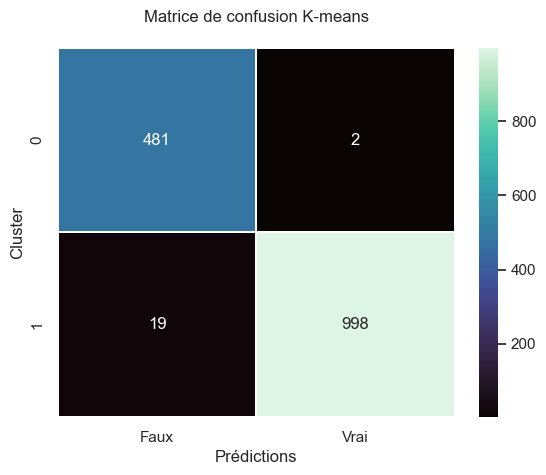

In [83]:
# Graphique:
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")

Le cluster 0 correspond au Faux billets, le cluster 1 au Vrai billet.

In [84]:
vrai_negatif = km_matrix.loc[0,0]
faux_negatif = km_matrix.loc[1,0]
faux_positif = km_matrix.loc[0,1]
vrai_positif = km_matrix.loc[1,1]

# Calcul de la précision
Taux_precision = (float (vrai_positif + vrai_negatif) / float(vrai_negatif + faux_positif + faux_negatif + vrai_positif))
print('Le taux precision est', round((Taux_precision)*100,2), '%')

Taux_erreur = (faux_positif + faux_negatif) / (vrai_negatif+faux_positif+faux_negatif+vrai_positif)
print('Le taux erreur est de', round((Taux_erreur)*100,2), '%')

Le taux precision est 98.6 %
Le taux erreur est de 1.4 %


## 5.4 Test du modèle

In [85]:
# Prédictions sur des données inconnues :

x_test_km = Billets_test_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]

Billets_test_df["cluster_pred"] = km.predict(x_test_km)
print(Billets_test_df[["id","cluster_pred"]])

    id  cluster_pred
0  A_1             0
1  A_2             0
2  A_3             0
3  A_4             1
4  A_5             1


## 6. Conclusion générale

## Df fINALISE

In [86]:
Billets_data.head(5)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72            1    171.94       103.89        103.45    4.064954       3.25   
99            1    171.93       104.07        104.18    4.111990       3.14   
151           1    172.07       103.80        104.38    4.134003       3.02   
197           1    171.45       103.66        103.80    3.993571       3.62   
241           1    171.83       104.14        104.06    4.140399       3.02   

     length     proba  y_pred cluster_km  
72   112.79  0.997694       1          1  
99   113.08  0.998127       1          1  
151  112.93  0.996980       1          1  
197  113.27  0.988619       1          1  
241  112.36  0.964849       1          1

In [87]:
# Suppression des colonnes superflues et sauvegarder
billet_Finalisé = Billets_data.drop(columns=["proba", "y_pred"])

In [88]:
# Sauvegarde fichier Billet_df 
billet_Finalisé.to_csv("billet_Finalisé.csv")

## CODE TEST SOUTENANCE

In [89]:
## Bibliothèque Test 
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import Logit

## Import des données

In [90]:
#Training set
Billet_df = pd.read_csv("billets_test.csv") # à remplacer par le nom de la df fourni en soutenance !
Billet_df.head(1)

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1

In [91]:
 #Testing set 
Billets_test_df = pd.read_csv("billets_test.csv")  # à remplacer par le nom de la df fourni en soutenance !
Billets_test_df.head(1)

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1

In [92]:
#On verrifira le nom du fichier et que la colonne id est bien présente
Billets_test_df.info()                                                                    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 412.0+ bytes


In [93]:
# Prédictions sur des données de test :

x_test_km = Billets_test_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]

Billets_test_df["cluster_pred"] = km.predict(x_test_km)
print(Billets_test_df[["id","cluster_pred"]])

    id  cluster_pred
0  B_1             1
1  B_2             0
2  B_3             1
3  B_4             0
4  B_5             0


In [94]:
# Affichage des resultats:
print("\nIndetification des billets:\n")
for i, k in zip(Billets_test_df["cluster_pred"],Billets_test_df["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")


Indetification des billets:

Le billet B_1 est vrai
Le billet B_2 est faux
Le billet B_3 est vrai
Le billet B_4 est faux
Le billet B_5 est faux


## merci de votre attention, avez-vous des questions ?